# Real-time In-session Personalization
> Personalization with deep learning in 100 lines of code using Elasticsearch, Redis and Word2vec

- toc: true
- badges: true
- comments: true
- categories: [Elasticsearch, Redis, Word2vec, Visualization, Session, Sequential, Embedding, RealTime, Retail]
- image:

### Introduction

| |  |
| :-: | -:|
| Vision | Personalizing Customer's In-session experience in real-time |
| Mission | Learn embeddings for a small sequetial dataset and use efficient indexing and database techniques to retrieve results in real-time |
| Scope | Synthetic dataset, Model training, indexing and retrieval, eCommerce space |
| Task | Next-item Prediction |
| Data | Synthetic Sequential |
| Tool | Word2vec, Elasticsearch, Redis, Colab |
| Technique | Word2vec for embedding, Elasticsearch for indexing, Redis for in-memory fast retrieval |
| Process | 1) Setup environment by installing and starting elaticsearch, redis backend server, 2) Generate synthetic data, 3) Train the embedding model, 4) Visualize the results, 5) Index the embedding vectors, 6) Retrieve the top-k results in real-time |
| Takeaway | Elasticsearch and Redis - a good combination for fast and efficient retrieval at scale, Word2vec is simple yet effective entry-level technique for learning sequential embeddings |
| Credit | [Jacopo Tagliabue](https://github.com/jacopotagliabue/clothes-in-space) |
| Link | [link1](https://github.com/jacopotagliabue), [link2](https://blog.coveo.com/clothes-in-space-real-time-personalization-in-less-than-100-lines-of-code/) |

### Install Elasticsearch

In [ ]:
!wget https://artifacts.elastic.co/downloads/elasticsearch/elasticsearch-oss-7.0.5-linux-x86_64.tar.gz

--2021-07-18 07:27:11--  https://artifacts.elastic.co/downloads/elasticsearch/elasticsearch-oss-7.0.5-linux-x86_64.tar.gz
Resolving artifacts.elastic.co (artifacts.elastic.co)... 34.120.127.130, 2600:1901:0:1d7::
Connecting to artifacts.elastic.co (artifacts.elastic.co)|34.120.127.130|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2021-07-18 07:27:11 ERROR 404: Not Found.



In [ ]:
%%bash

wget -q https://artifacts.elastic.co/downloads/elasticsearch/elasticsearch-oss-7.0.1-linux-x86_64.tar.gz
wget -q https://artifacts.elastic.co/downloads/elasticsearch/elasticsearch-oss-7.0.1-linux-x86_64.tar.gz.sha512
tar -xzf elasticsearch-oss-7.0.1-linux-x86_64.tar.gz
sudo chown -R daemon:daemon elasticsearch-7.0.1/
shasum -a 512 -c elasticsearch-oss-7.0.1-linux-x86_64.tar.gz.sha512 

elasticsearch-oss-7.0.1-linux-x86_64.tar.gz: OK


Run the instance as a daemon process

In [ ]:
%%bash --bg

sudo -H -u daemon elasticsearch-7.0.1/bin/elasticsearch

Starting job # 0 in a separate thread.


In [ ]:
# Sleep for few seconds to let the instance start.
import time
time.sleep(20)

Once the instance has been started, grep for `elasticsearch` in the processes list to confirm the availability.

In [ ]:
%%bash

ps -ef | grep elasticsearch

root         244       1  0 05:33 ?        00:00:00 sudo -H -u daemon elasticsearch-7.9.2/bin/elasticsearch
daemon       245     244  0 05:33 ?        00:00:34 /content/elasticsearch-7.9.2/jdk/bin/java -Xshare:auto -Des.networkaddress.cache.ttl=60 -Des.networkaddress.cache.negative.ttl=10 -XX:+AlwaysPreTouch -Xss1m -Djava.awt.headless=true -Dfile.encoding=UTF-8 -Djna.nosys=true -XX:-OmitStackTraceInFastThrow -XX:+ShowCodeDetailsInExceptionMessages -Dio.netty.noUnsafe=true -Dio.netty.noKeySetOptimization=true -Dio.netty.recycler.maxCapacityPerThread=0 -Dio.netty.allocator.numDirectArenas=0 -Dlog4j.shutdownHookEnabled=false -Dlog4j2.disable.jmx=true -Djava.locale.providers=SPI,COMPAT -Xms1g -Xmx1g -XX:+UseG1GC -XX:G1ReservePercent=25 -XX:InitiatingHeapOccupancyPercent=30 -Djava.io.tmpdir=/tmp/elasticsearch-278431634431622414 -XX:+HeapDumpOnOutOfMemoryError -XX:HeapDumpPath=data -XX:ErrorFile=logs/hs_err_pid%p.log -Xlog:gc*,gc+age=trace,safepoint:file=logs/gc.log:utctime,pid,tags:filecoun

query the base endpoint to retrieve information about the cluster.

In [ ]:
%%bash

curl -sX GET "localhost:9201/"

{
  "name" : "106eaf552057",
  "cluster_name" : "elasticsearch",
  "cluster_uuid" : "tbMnpTtSTOeqwDan3GKphg",
  "version" : {
    "number" : "7.9.2",
    "build_flavor" : "oss",
    "build_type" : "tar",
    "build_hash" : "d34da0ea4a966c4e49417f2da2f244e3e97b4e6e",
    "build_date" : "2020-09-23T00:45:33.626720Z",
    "build_snapshot" : false,
    "lucene_version" : "8.6.2",
    "minimum_wire_compatibility_version" : "6.8.0",
    "minimum_index_compatibility_version" : "6.0.0-beta1"
  },
  "tagline" : "You Know, for Search"
}


In [ ]:
%%bash

curl -sX GET "localhost:9201/"

{
  "name" : "106eaf552057",
  "cluster_name" : "elasticsearch",
  "cluster_uuid" : "tbMnpTtSTOeqwDan3GKphg",
  "version" : {
    "number" : "7.0.1",
    "build_flavor" : "oss",
    "build_type" : "tar",
    "build_hash" : "e4efcb5",
    "build_date" : "2019-04-29T12:56:03.145736Z",
    "build_snapshot" : false,
    "lucene_version" : "8.0.0",
    "minimum_wire_compatibility_version" : "6.7.0",
    "minimum_index_compatibility_version" : "6.0.0-beta1"
  },
  "tagline" : "You Know, for Search"
}


### Install Redis

In [ ]:
!wget http://download.redis.io/releases/redis-stable.tar.gz --no-check-certificate
!tar -xf redis-stable.tar.gz && cd redis-stable/src && make

In [ ]:
! nohup ./redis-stable/src/redis-server > redis_nohup.out &
! cat redis_nohup.out

nohup: redirecting stderr to stdout
5863:C 18 Jul 2021 05:46:12.258 # oO0OoO0OoO0Oo Redis is starting oO0OoO0OoO0Oo
5863:C 18 Jul 2021 05:46:12.258 # Redis version=6.0.5, bits=64, commit=00000000, modified=0, pid=5863, just started
5863:C 18 Jul 2021 05:46:12.258 # Warning: no config file specified, using the default config. In order to specify a config file use ./redis-stable/src/redis-server /path/to/redis.conf
5863:M 18 Jul 2021 05:46:12.259 * Running mode=standalone, port=6379.
5863:M 18 Jul 2021 05:46:12.259 # Server initialized
5863:M 18 Jul 2021 05:46:12.259 # WARNING you have Transparent Huge Pages (THP) support enabled in your kernel. This will create latency and memory usage issues with Redis. To fix this issue run the command 'echo never > /sys/kernel/mm/transparent_hugepage/enabled' as root, and add it to your /etc/rc.local in order to retain the setting after a reboot. Redis must be restarted after THP is disabled.
5863:M 18 Jul 2021 05:46:12.260 * Ready to accept connecti

In [ ]:
!pip install redis

import redis
r = redis.StrictRedis(host="127.0.0.1", port=6379)

     |████████████████████████████████| 81kB 5.6MB/s 


### Generate Synthetic Data

In [ ]:
%%writefile catalog.csv
sku,name,target,image
01111,shoesA,men,"https://static.nike.com/a/images/c_limit,w_592,f_auto/t_product_v1/e706a692-be9e-4d5a-9537-3d64bd2d0e34/blazer-mid-77-shoe-9SvVxB.png"
01112,shoesB,women,"https://static.nike.com/a/images/c_limit,w_592,f_auto/t_product_v1/b98cdc08-0691-48a8-99f7-bd4856ab5628/air-force-1-07-shoe-AKTdww3y.png"
01113,shoesC,men,"https://static.nike.com/a/images/c_limit,w_592,f_auto/t_product_v1/fe07ff2a-e259-4664-b83e-003f68dfaf62/air-max-96-2-shoe-6l7J5T.png"
01114,shoesD,men,"https://static.nike.com/a/images/c_limit,w_592,f_auto/t_product_v1/9313fb42-b9fb-4a13-bd94-46137fd19c12/air-jordan-1-mid-se-shoe-zgPD6z.png"
01115,shoesE,women,"https://static.nike.com/a/images/c_limit,w_592,f_auto/t_product_v1/e1eaf5d3-dfca-4bba-b0f3-2f356520b655/blazer-mid-77-se-shoe-97H9PZ.png"
01116,tshirtA,women,"https://static.nike.com/a/images/c_limit,w_592,f_auto/t_product_v1/a7f6f9ff-8fd2-4acc-b547-8ea5497e9def/nikelab-t-shirt-Q89CVt.png"
01117,tshirtB,women,"https://static.nike.com/a/images/c_limit,w_592,f_auto/t_product_v1/a7b40e60-9626-4538-bdbb-51a0e85da6d3/dri-fit-race-short-sleeve-running-top-h2qbZD.png"
01118,tshirtC,women,"https://static.nike.com/a/images/c_limit,w_592,f_auto/t_product_v1/46752967-b4eb-4d9b-8150-75901f3e87a8/dri-fit-run-division-running-tank-K7wCpp.png"
01119,tshirtD,men,"https://static.nike.com/a/images/c_limit,w_592,f_auto/t_product_v1/f20341c3-0620-4430-9c04-783f9b507789/sb-skate-t-shirt-LHlzwG.png"
01120,tshirtE,men,"https://static.nike.com/a/images/c_limit,w_592,f_auto/t_product_v1/259734bd-93b6-420e-adc6-31cb187e4442/dri-fit-superset-short-sleeve-training-top-6LKnxr.png"

Overwriting catalog.csv


In [ ]:
%%writefile sessions.txt
0	01112 01115 01115 01112
1	01118 01116 01120 01118 01117 01116 01118
2	01113 01114 01114 01111 01111 01113
3 01116 01117
4 01111 01113 01114 01118 01113 01114 01111
5 01117 01117 01118 01116
6	01112 01112 01115 01112
7	01120 01120 01119 01120 01119 01120
8	01113 01114 01114 01111 01113
9 01116 01117 01116 01117 01118
10 01111 01113 01114 01119 01120 01119
11 01117 01117 01118 01116

Overwriting sessions.txt


### Import and global variables

In [ ]:
import os
import csv
from datetime import datetime
import string
import requests
import json
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
import redis  # to communicate with redis
import gensim # to talk to gensim
from IPython.display import Image  # to display URL in noteboook for visual debug
from IPython.core.display import display # to display URL in noteboook for visual debug
from elasticsearch import Elasticsearch, helpers # remember to !pip install elasticsearch

In [ ]:
DATA_FOLDER = ''
CATALOGUE_FILE = os.path.join(DATA_FOLDER, 'catalog.csv')
SESSION_FILE = os.path.join(DATA_FOLDER, 'sessions.txt')

In [ ]:
EMBEDDING_DIMS = 5 # specify embedding size

### Python clients for Redis and ElasticSearch

In [ ]:
# redis credentials here!
REDIS_HOST = 'localhost'
REDIS_PORT = 6379
REDIS_DB = 0
REDIS_PWD = None
# redis data structure
REDIS_HASH_FORMAT = 'product_h'
# start redis client
redis_client = redis.StrictRedis(host=REDIS_HOST, 
                                 port=REDIS_PORT, 
                                 db=REDIS_DB, 
                                 password=REDIS_PWD)

In [ ]:
INDEX_NAME = 'catalog'
ES_HOST = {"host": "localhost", "port": 9200}
# if you're running with the docker-compose option and not the manuel docker instance, use:
# ES_HOST = {"host": "elasticsearch", "port": 9200}
es_client = Elasticsearch(hosts=[ES_HOST])

### Train Embeddings

_First of all, get products from the catalogue dump into a usable form_

In [ ]:
# First of all, get products from the catalogue dump into a usable form
def get_products_from_catalogue(catalog_file):
    """
    parse catalogue file into a map SKU -> properties (sku, name, target, image url)
    """
    products = {}
    with open(catalog_file) as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            if row['sku'] and row['image'].endswith('.png'):
                products[row['sku']] = row
    
    return products

In [ ]:
products = get_products_from_catalogue(CATALOGUE_FILE)
print('{} products in catalog!'.format(len(products)))
dict(list(products.items())[0:3])

10 products in catalog!


{'01111': OrderedDict([('sku', '01111'),
              ('name', 'shoesA'),
              ('target', 'men'),
              ('image',
               'https://static.nike.com/a/images/c_limit,w_592,f_auto/t_product_v1/e706a692-be9e-4d5a-9537-3d64bd2d0e34/blazer-mid-77-shoe-9SvVxB.png')]),
 '01112': OrderedDict([('sku', '01112'),
              ('name', 'shoesB'),
              ('target', 'women'),
              ('image',
               'https://static.nike.com/a/images/c_limit,w_592,f_auto/t_product_v1/b98cdc08-0691-48a8-99f7-bd4856ab5628/air-force-1-07-shoe-AKTdww3y.png')]),
 '01113': OrderedDict([('sku', '01113'),
              ('name', 'shoesC'),
              ('target', 'men'),
              ('image',
               'https://static.nike.com/a/images/c_limit,w_592,f_auto/t_product_v1/fe07ff2a-e259-4664-b83e-003f68dfaf62/air-max-96-2-shoe-6l7J5T.png')])}

In [ ]:
def train_embedding_model(training_data):
    """
    training_data is a list of lists (list of words, products, etc.)
    
    """
    # train model with standard params
    model = gensim.models.Word2Vec(training_data,
                                   min_count=1,
                                   sample=1,
                                   size=EMBEDDING_DIMS,
                                   workers=-1,
                                   window=3,
                                   iter=20)
    vectors = model.wv
    # remove model from memory
    del model
    
    # return vectors as TOKEN -> VECTOR map
    return vectors

def solve_vector_analogy(vectors, man, king, women):
    # MAN : KING = WOMAN : ? -> QUEEN
    return vectors.most_similar_cosmul(positive=[king, women], negative=[man])

In [ ]:
def get_products_from_sessions(session_file):
    """
        Our file from the analytics service conveniently dumps, line by line,
        user sessions. We just read the file and return a list of lists!
        
        Every line is:
        
        LINE_ID (as INT) TAB PRODUCT 1 TAB PRODUCT 2 ...
        
        P.s.: our file has been pre-processed to include only session with length >= 3 and < 200
    """
    sessions = []
    with open(session_file) as session_f:
        for line in session_f:
            products = line.strip().split(' ')[1:]
            sessions.append(products)
        
    return sessions

In [ ]:
training_session_data = get_products_from_sessions(SESSION_FILE)
print('Total sessions: {}, first is: {}'.format(len(training_session_data), training_session_data[0]))

Total sessions: 12, first is: ['01115', '01115', '01112']


In [ ]:
product_embeddings = train_embedding_model(training_session_data)

### Visualize Results

_Check item-item similarity by looking at product vectors close together in the space_

For this:


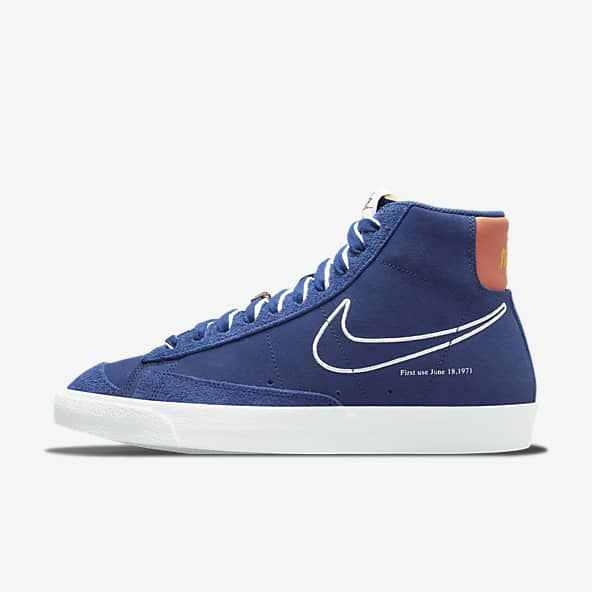


Recommendation 1:


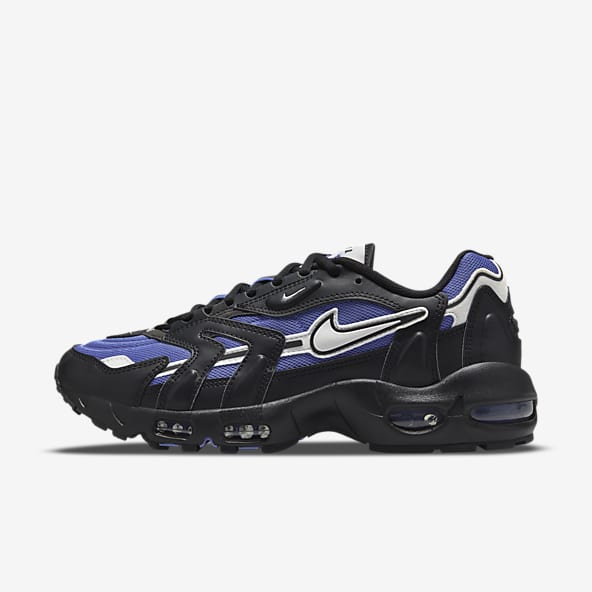


Recommendation 2:


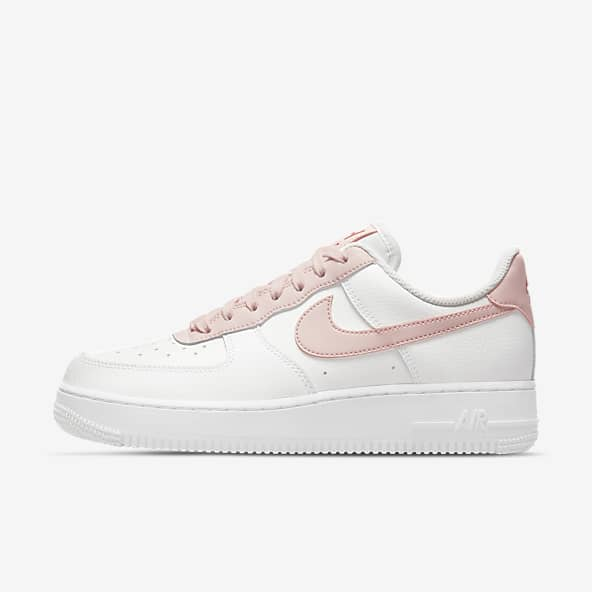

In [ ]:
TEST_PRODUCT = '01111'

matches = product_embeddings.most_similar_cosmul(positive=[TEST_PRODUCT])
# display top N
print("For this:")
display(Image(products[TEST_PRODUCT]['image'], width=150, unconfined=True))
for i,m in enumerate(matches[:2]):
    print("\nRecommendation {}:".format(i+1))
    display(Image(products[m[0]]['image'], width=150, unconfined=True))

For this:


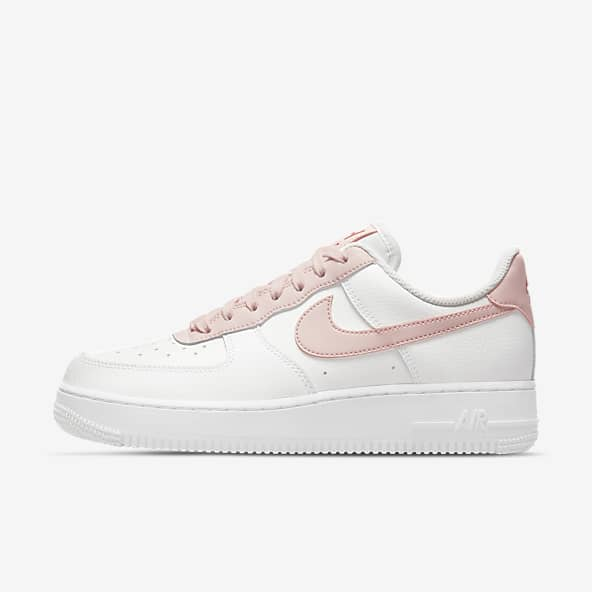


Recommendation 1:


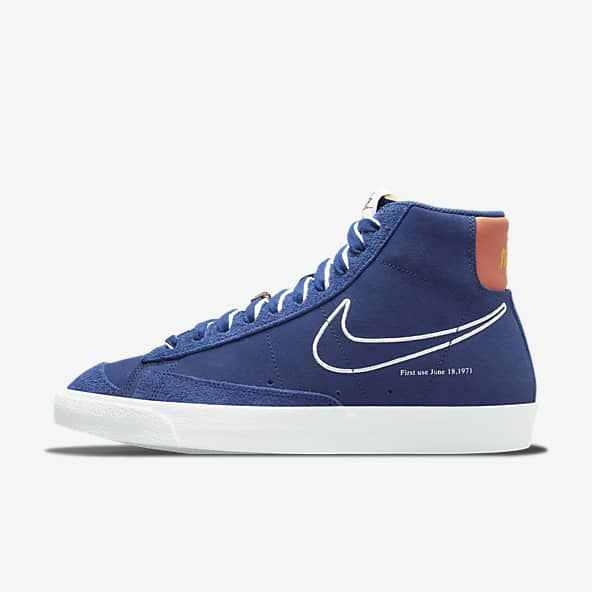


Recommendation 2:


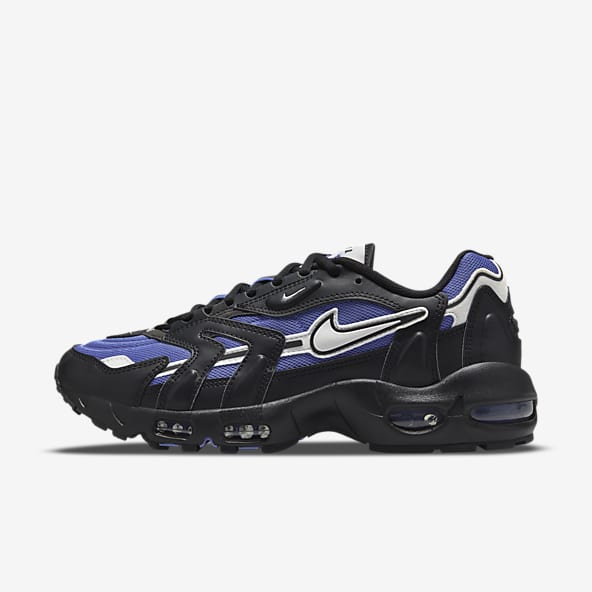

In [ ]:
TEST_PRODUCT = '01112'

matches = product_embeddings.most_similar_cosmul(positive=[TEST_PRODUCT])
# display top N
print("For this:")
display(Image(products[TEST_PRODUCT]['image'], width=150, unconfined=True))
for i,m in enumerate(matches[:2]):
    print("\nRecommendation {}:".format(i+1))
    display(Image(products[m[0]]['image'], width=150, unconfined=True))

For this:


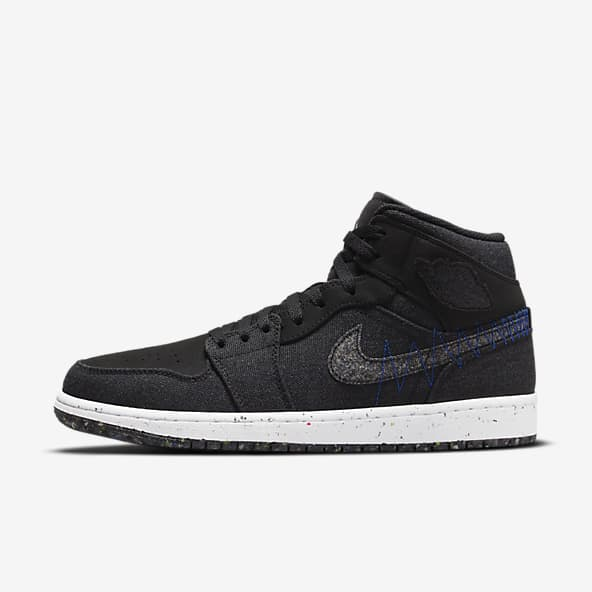


Recommendation 1:


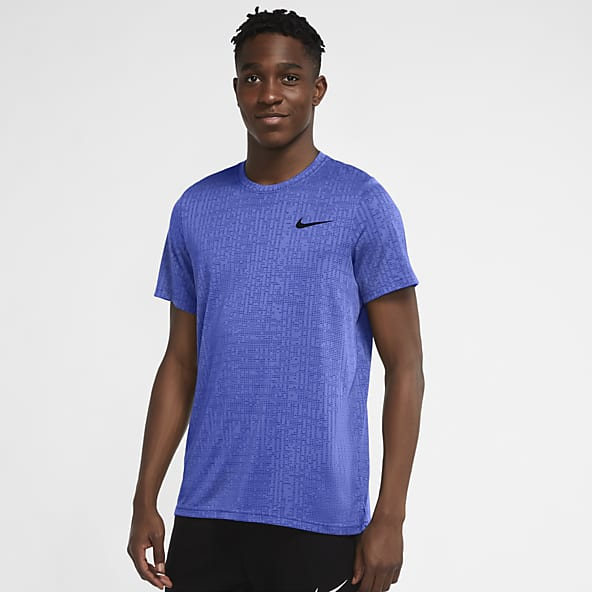


Recommendation 2:


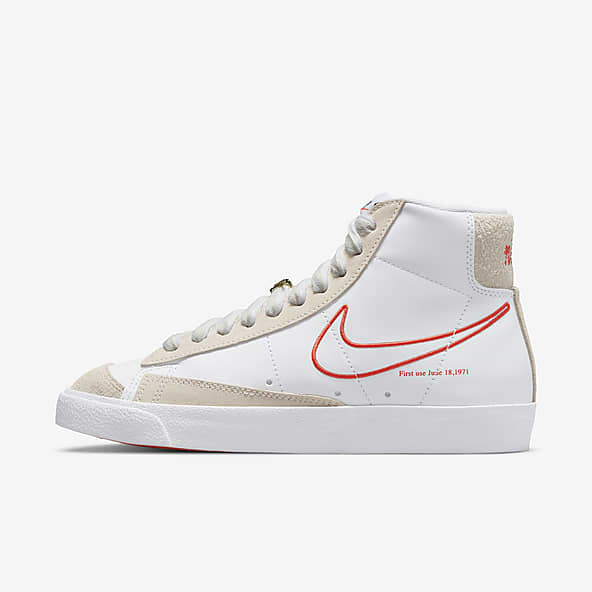

In [ ]:
TEST_PRODUCT = '01114'

matches = product_embeddings.most_similar_cosmul(positive=[TEST_PRODUCT])
# display top N
print("For this:")
display(Image(products[TEST_PRODUCT]['image'], width=150, unconfined=True))
for i,m in enumerate(matches[:2]):
    print("\nRecommendation {}:".format(i+1))
    display(Image(products[m[0]]['image'], width=150, unconfined=True))

For this:


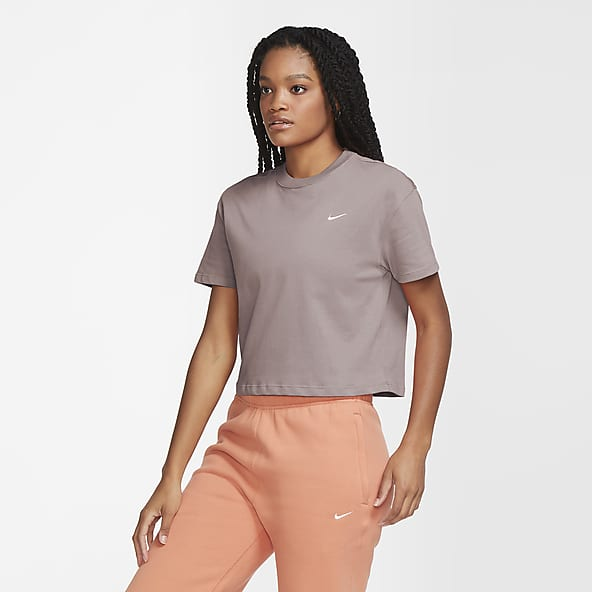


Recommendation 1:


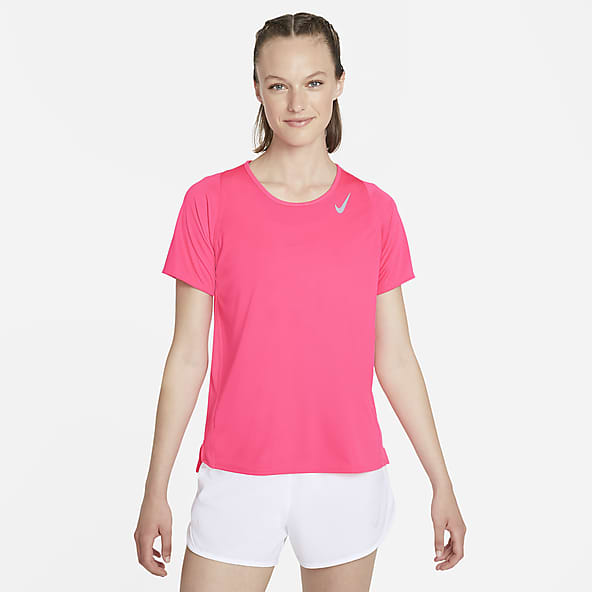


Recommendation 2:


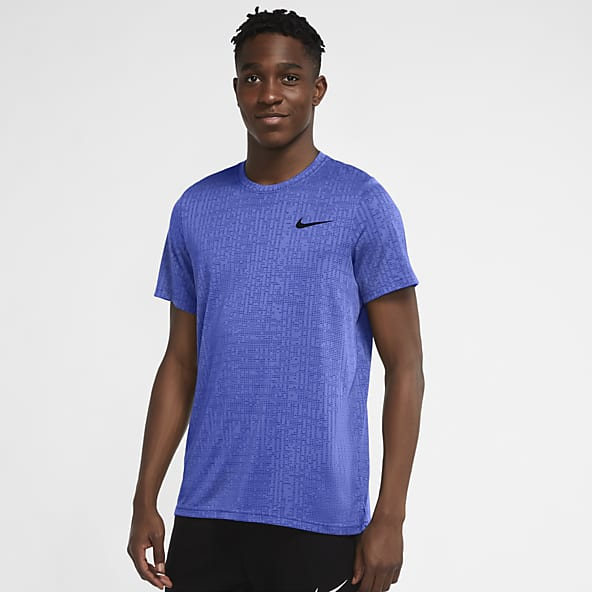

In [ ]:
TEST_PRODUCT = '01116'

matches = product_embeddings.most_similar_cosmul(positive=[TEST_PRODUCT])
# display top N
print("For this:")
display(Image(products[TEST_PRODUCT]['image'], width=150, unconfined=True))
for i,m in enumerate(matches[:2]):
    print("\nRecommendation {}:".format(i+1))
    display(Image(products[m[0]]['image'], width=150, unconfined=True))

For this:


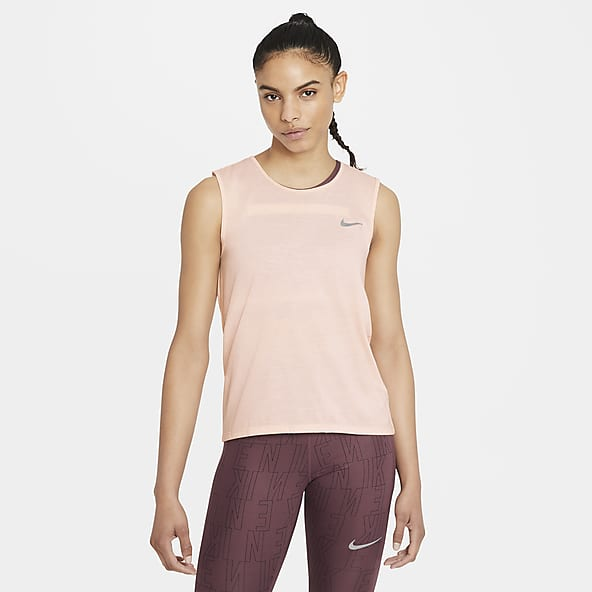


Recommendation 1:


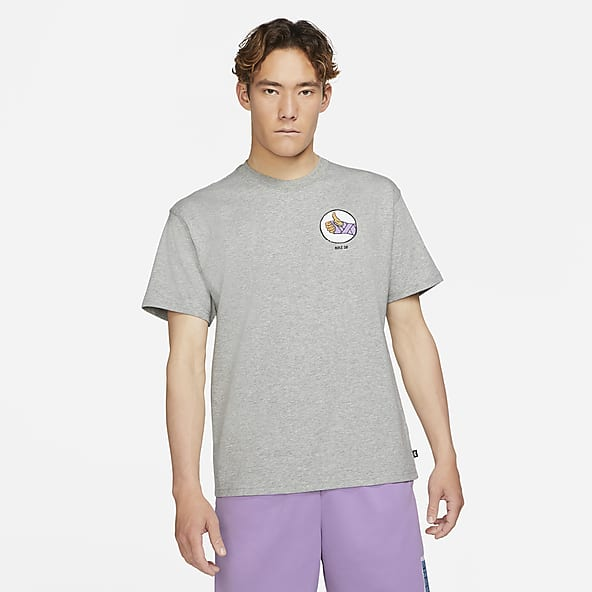


Recommendation 2:


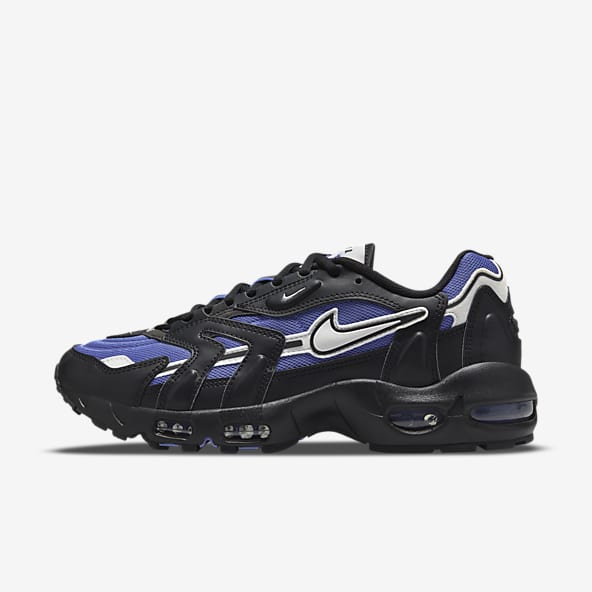

In [ ]:
TEST_PRODUCT = '01118' 

matches = product_embeddings.most_similar_cosmul(positive=[TEST_PRODUCT])
# display top N
print("For this:")
display(Image(products[TEST_PRODUCT]['image'], width=150, unconfined=True))
for i,m in enumerate(matches[:2]):
    print("\nRecommendation {}:".format(i+1))
    display(Image(products[m[0]]['image'], width=150, unconfined=True))

For this:


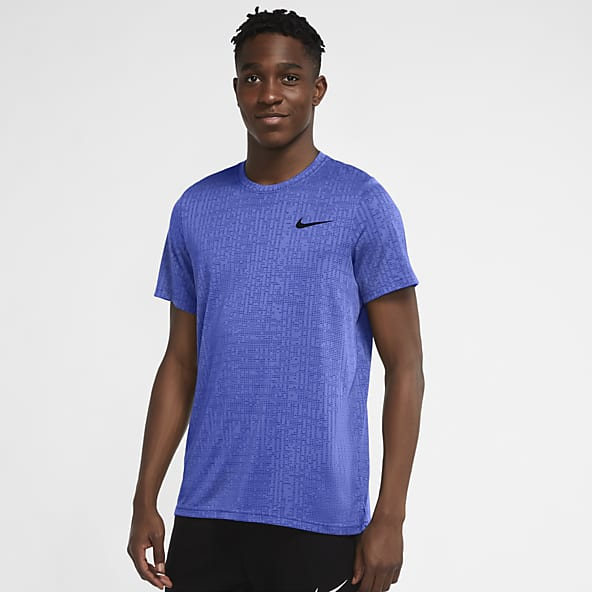


Recommendation 1:


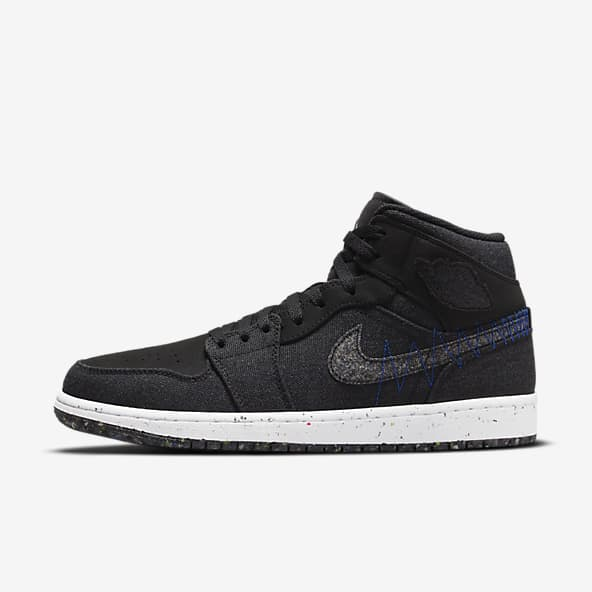


Recommendation 2:


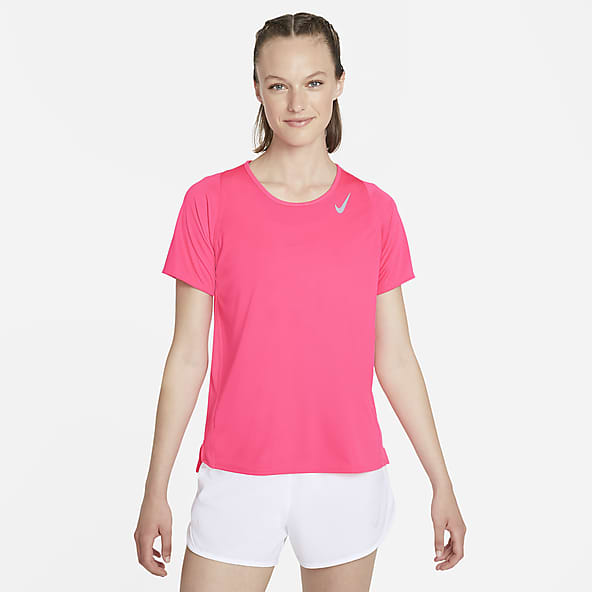

In [ ]:
TEST_PRODUCT = '01120' 

matches = product_embeddings.most_similar_cosmul(positive=[TEST_PRODUCT])
# display top N
print("For this:")
display(Image(products[TEST_PRODUCT]['image'], width=150, unconfined=True))
for i,m in enumerate(matches[:2]):
    print("\nRecommendation {}:".format(i+1))
    display(Image(products[m[0]]['image'], width=150, unconfined=True))

### Vector Analogy

_Playing with some analogies here_

> Note: if women shoes goes with women tshirt, then men shoes goes with what?

In [ ]:
# fill here with your product IDs to test for analogies
PRODUCT1 = '01112'
PRODUCT1_MATCH = '01117'
PRODUCT2 = '01113'

In [ ]:
assert all(_ in product_embeddings.vocab for _ in [PRODUCT1, PRODUCT1_MATCH, PRODUCT2])

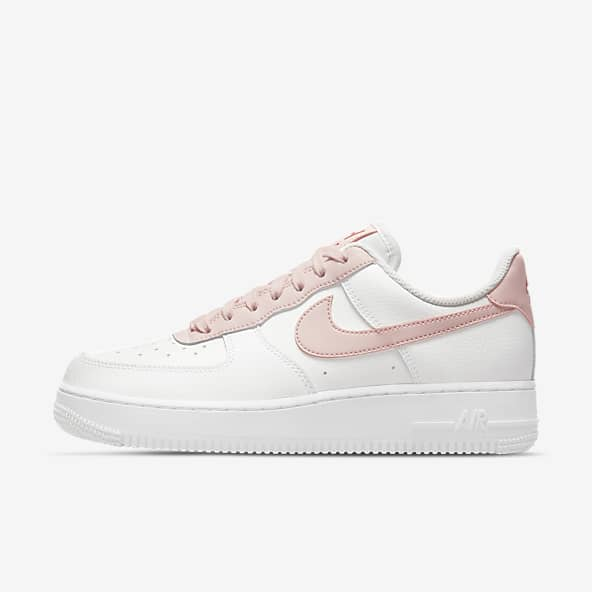

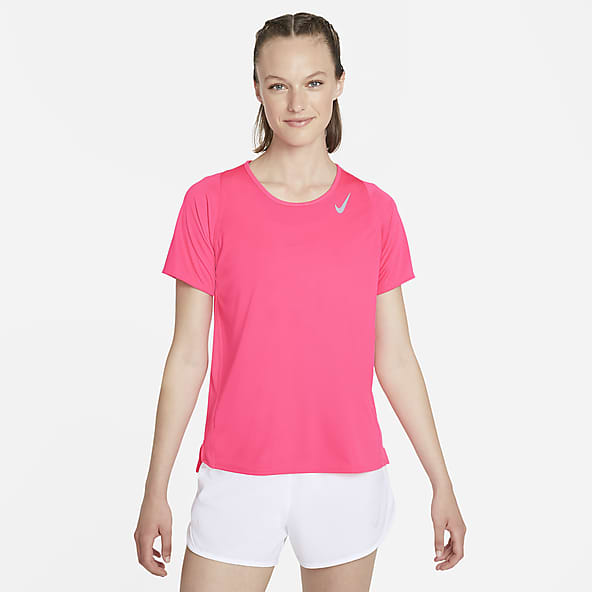

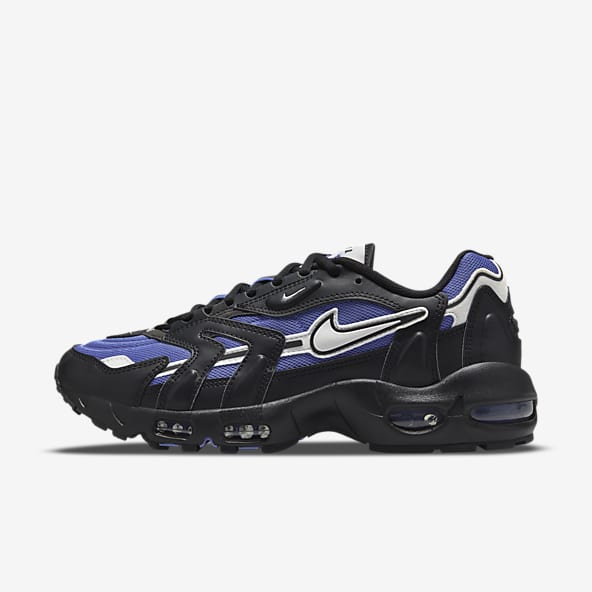

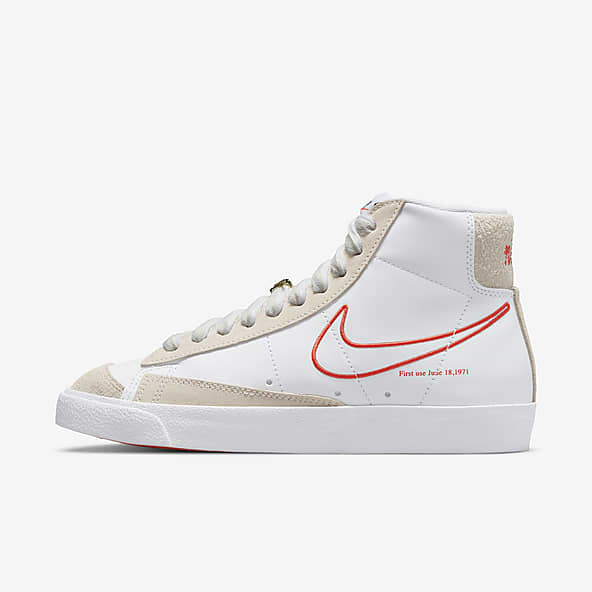

In [ ]:
matches = solve_vector_analogy(product_embeddings, PRODUCT1, PRODUCT1_MATCH, PRODUCT2)
# first show products
for _ in [PRODUCT1, PRODUCT1_MATCH, PRODUCT2]:
    display(Image(products[_]['image'], width=100, unconfined=True))
# then display matches
for m in matches[:1]:
    if m[0] in products:
        display(Image(products[m[0]]['image'], width=100, unconfined=True))

> Warning: Analogy test failed.

_Finally, we add the vectors to our product dictionary_

In [ ]:
# add vector to products
for sku, p in products.items():
    p['vector'] = product_embeddings[p['sku']].tolist() if p['sku'] in product_embeddings else None
    p['popularity'] = random.randint(0, 1000)  # add a popularity field to fake popularity data for later retrieval
# remove products without vectors for simplicity
products = {k: v for k,v in products.items() if v['vector'] is not None}
len(products)

10

### Personalizing search

In [ ]:
def re_rank_results(session_vector, skus):
    results_vectors = retrieve_vectors_from_redis(skus)
    distance_matrix = cosine_similarity(session_vector.reshape(1, -1), results_vectors)[0]
    so = np.argsort(distance_matrix)
    return list(reversed(list(np.array(skus)[so])))

> Tip: dense_vector data type comes with premium version of elasticsearch (line #23 in the below cell). So we used text field instead.

In [ ]:
def upload_docs_to_es(index_name, docs):
    """
    index_name is a string 
    docs is a map doc id -> doc as a Python dictionary (in our case SKU -> product)
    """
    # first we delete an index with the same name if any 
    # ATTENTION: IF YOU USE THIS CODE IN THE REAL WORLD THIS LINE WILL DELETE THE INDEX
    if es_client.indices.exists(index_name):
        print("Deleting {}".format(index_name))
        es_client.indices.delete(index=index_name)    
    # next we define our index
    body = {
        'settings': {
            "number_of_shards" : 1,
            "number_of_replicas" : 0
        },
        "mappings": {
          "properties": {
                "name": { "type": "text"},
                "target": { "type": "text" },
                "image": { "type": "text" } ,
                "vector": {
                      # "type": "dense_vector",
                      "type": "text",
                      "dims": EMBEDDING_DIMS
                    }
            }
        }
    }
    # create index
    res = es_client.indices.create(index=index_name, body=body)
    # finally, we bulk upload the documents
    actions = [{
                   "_index": index_name,
                   "_id": sku,
                   "_source": doc
               } for sku, doc in docs.items()
            ]
    # bulk upload
    res = helpers.bulk(es_client, actions)
    
    return res

def query_with_es(index_name, search_query, n=5):
    search_query = {
        "from": 0,
        "size": n,
        "query" : {
            "script_score" : {
                "query": {
                        "match" : {
                            "name" : {
                                "query" : search_query
                            }
                        }
                    },
                "script": {
                  "source" : "doc['popularity'].value / 10"
                }
            }
         }
    }
    res = es_client.search(index=index_name, body=search_query)
    print("Total hits: {}, returned {}\n".format(res['hits']['total']['value'], len(res['hits']['hits'])))
    return [(hit["_source"]['sku'], hit["_source"]['image']) for hit in res['hits']['hits']]

def query_and_display_results_with_es(index_name, search_query, n=5):
    res = query_with_es(index_name, search_query, n=n)
    return display_image(res)

def display_image(skus, n=5):
    for (s, image) in skus[:n]:
        print('{} - {}\n'.format(s, image))
        display(Image(image, width=150, unconfined=True))
            
def query_and_rerank_and_display_results_with_es(index_name, search_query, n, session_vector):
    res = query_with_es(index_name, search_query, n=n)
    skus = [r[0] for r in res]
    re_ranked_sku = re_rank_results(session_vector, skus)

    return display_image([(sku, res[skus.index(sku)][1]) for sku in re_ranked_sku])

In [ ]:
upload_result = upload_docs_to_es(INDEX_NAME, products)
upload_result

(10, [])

In [ ]:
es_client.indices.refresh(INDEX_NAME)
resp = es_client.get(index=INDEX_NAME, id=PRODUCT1)
print(resp)

{'_index': 'catalog', '_type': '_doc', '_id': '01112', '_version': 1, '_seq_no': 1, '_primary_term': 1, 'found': True, '_source': {'sku': '01112', 'name': 'shoesB', 'target': 'women', 'image': 'https://static.nike.com/a/images/c_limit,w_592,f_auto/t_product_v1/b98cdc08-0691-48a8-99f7-bd4856ab5628/air-force-1-07-shoe-AKTdww3y.png', 'vector': [-0.09506063908338547, 0.01327930111438036, 0.02451828122138977, 0.09916432201862335, 0.07408668100833893], 'popularity': 270}}


### Load data into Redis

> Note: To simulate a real-time use case

In [ ]:
def redis_upload(redis_client, rows):
    with redis_client.pipeline() as pipe:
        for r in rows:
            pipe.hset(REDIS_HASH_FORMAT, r['sku'], json.dumps(r))
        res = pipe.execute()
    
    return

def load_vectors_to_cache(products, batch_size):
    # first we flush the cache
    # ATTENTION: IF YOU USE THIS CODE IN THE REAL WORLD THIS LINE WILL DELETE ALL DATA
    redis_client.flushall()
    # upload data in bulk with pipeline
    rows = list(products.values())
    for i in range(0, len(rows), batch_size):
        print("Uploading {} rows {} at {}...".format(len(rows), i, datetime.utcnow()))
        redis_upload(redis_client, rows[i: i + batch_size])
    # do some test
    print(redis_client.hmget(REDIS_HASH_FORMAT, [r['sku'] for r in rows[:1]]))
    #return total number of rows uploaded
    return len(rows)

In [ ]:
load_vectors_to_cache(products, batch_size=5)

Uploading 10 rows 0 at 2021-07-18 07:48:46.480836...
Uploading 10 rows 5 at 2021-07-18 07:48:46.481941...
[b'{"sku": "01111", "name": "shoesA", "target": "men", "image": "https://static.nike.com/a/images/c_limit,w_592,f_auto/t_product_v1/e706a692-be9e-4d5a-9537-3d64bd2d0e34/blazer-mid-77-shoe-9SvVxB.png", "vector": [-0.027305342257022858, -0.020312489941716194, -0.0527806393802166, 0.04385489597916603, 0.09405443072319031], "popularity": 330}']


10

In [ ]:
QUERY1 = '"match_all":{}' # put here the first query to test
QUERY2 = '' # put here the second query to test
TOP_N = 5 # top N results to re-rank

In [ ]:
def get_products_from_catalogue(catalog_file):
    """
    parse catalogue file into a map SKU -> properties (sku, name, target, image url)
    """
    products = {}
    with open(catalog_file) as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            if row['sku'] and row['image'].endswith('.jpg'):
                products[row['sku']] = row
    
    return products

In [ ]:
products = get_products_from_catalogue(CATALOGUE_FILE)
print('{} products in catalog!'.format(len(products)))

### Query ES

_First, we query ES for a "vanilla" search_

In [ ]:
query_and_display_results_with_es(INDEX_NAME, QUERY1, TOP_N)

_Now, we retrieve from Redis the vectors for products in the session_

In [ ]:
def build_average_vector(vectors, v_shape):
    """
    not exactly fancy, but... 
    see for example https://districtdatalabs.silvrback.com/modern-methods-for-sentiment-analysis
    """
    category_vec = np.zeros(v_shape[0]).reshape(v_shape)
    for v in vectors:
        assert v.shape == category_vec.shape
        category_vec += v
    
    return category_vec / len(vectors)

In [ ]:
def retrieve_vectors_from_redis(skus):
    session_products = redis_client.hmget(REDIS_HASH_FORMAT, skus)
    return [np.array(json.loads(s)["vector"]) for s in session_products if s]

def retrieve_session_vector_from_redis(products_in_session):
    session_vectors = retrieve_vectors_from_redis(products_in_session)
    
    return build_average_vector(session_vectors, session_vectors[0].shape)

In [ ]:
session_vector = retrieve_session_vector_from_redis(PRODUCTS_IN_SESSION)
# debug
print(len(session_vector), session_vector[:10])

_Finally use the session vector to query_

In [ ]:
query_and_rerank_and_display_results_with_es(INDEX_NAME, QUERY1, TOP_N, session_vector)

In [ ]:
# uncomment here if you like to use Coveo index instead
# query_and_rerank_and_display_results_with_coveo(QUERY1, TOP_N, session_vector)

_Try some other query_

In [ ]:
# vanilla query
query_and_display_results_with_es(INDEX_NAME, QUERY2, TOP_N)

In [ ]:
# now personalized
query_and_rerank_and_display_results_with_es(INDEX_NAME, QUERY2, TOP_N, session_vector)

### Appendix 1: word embeddings, where it all started

In [ ]:
def get_sentences_from_corpus(corpus_file, max_sentences=None):
    """
        Read the text file and process it as a list of lists, where each list is 
        the tokens in a sentence. Don't care too much about pre-processing,
        just get stuff done.
    """
    sentences = []
    with open(corpus_file) as c_file:
        for line in c_file:
            # remove punctuation, strip lines, lower case it and normalize spaces
            cleaned_line = ' '.join(line.translate(str.maketrans('', '', string.punctuation)).strip().lower().split())
            if not cleaned_line:
                continue
            sentences.append(cleaned_line.split())
            # check if we reached a max number of sentences for training
            if max_sentences and len(sentences) == max_sentences:
                return sentences
    
    return sentences

In [ ]:
# texts from 1BN words dataset - if you're using the docker-compose setup, change the path to tmp folder
TEXT_FILE = os.path.join(DATA_FOLDER, 'corpus.txt')  
MAX_SENTENCES = 1000000 # how many sentences to load for the word2vec example: keep it small if you don't like to wait!

In [ ]:
training_sentences_data = get_sentences_from_corpus(TEXT_FILE, max_sentences=MAX_SENTENCES)
print('Total sentences: {}, first is: {}'.format(len(training_sentences_data), training_sentences_data[0]))
word_embeddings = train_embedding_model(training_sentences_data)

_Now test similarities and play with analogies_

In [ ]:
for _ in ['paris', 'france']:
    print('###{}\n{}\n'.format(_, word_embeddings.most_similar_cosmul(positive=[_])))

In [ ]:
print("BOY : KING = WOMAN : {}\n".format(solve_vector_analogy(word_embeddings, 'boy', 'king', 'girl')[0][0]))
print("PARIS : FRANCE = BERLIN : {}\n".format(solve_vector_analogy(word_embeddings, 'paris', 'france', 'berlin')[0][0]))

### Appendix 2: how to visualize vectors and impress friends

In [ ]:
def visualize_word_embeddings_tsne(word_embeddings):
    # colors
    colors = ['red', 'green', 'blue', 'purple', 'yellow', 'black']
    interesting_word_groups = [
        (['he', 'she', 'it', 'they', 'i', 'you', 'we'], 'pronouns'),
        (['london', 'paris', 'berlin', 'budapest', 'amsterdam', 'prague', 'rome'], 'cities'),
        (['italy', 'germany', 'spain', 'romania', 'finland', 'poland', 'norway', 'sweden', 'austria', 'brazil'], 'countries'),
        (['pasta', 'pizza', 'steak', 'pie', 'fries', 'burger', 'salmon'], 'food'),
        (['john', 'mark', 'jane', 'jessica', 'donald', 'simon'], 'names'),
        ([random.choice(list(word_embeddings.vocab)) for _ in range(0, 100)], 'other')
    ]
    all_words = []
    for words, group in interesting_word_groups:
        for w in words:
            all_words.append(w)
    all_keys = [w for w in list(word_embeddings.vocab) if w in all_words]
    all_vectors = [word_embeddings[e] for e in all_keys]
    # get projection
    X_embedded = TSNE(n_components=2).fit_transform(all_vectors)
    word_2_emb = {k: e for k, e in zip(all_keys, X_embedded)}
    # divide groups
    data = []
    groups = []
    for words, group in interesting_word_groups:
        groups.append(group)
        data.append([word_2_emb[w] for w in words])
    print(groups, data[0])
    # create plot
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(1, 1, 1)
    # add groups
    for d, color, group in zip(data, colors, groups):
        x = [_[0] for _ in d]
        y = [_[1] for _ in d]
        ax.scatter(x, y, alpha=0.8, c=color, edgecolors='none', s=30, label=group)
    # show plot
    plt.title('Plot color-coded embeddings')
    plt.legend(loc=2)
    plt.show()
    
    return

visualize_word_embeddings_tsne(word_embeddings)

In [ ]:
def export_vectors_for_projector_visualization(product_2_vectors,
                                               product_2_label,
                                               target_folder):
    # map dictionary to list to preserve order when exporting
    all_p = [p for p in list(product_2_vectors.vocab) if (not product_2_label or p in product_2_label)]
    all_v = [product_2_vectors[p] for p in all_p]
    # write vectors
    with open(os.path.join(target_folder, 'vectors.tsv'), 'w') as v_f:
        for v in all_v:
            v_f.write('{}\n'.format('\t'.join(['{:.5f}'.format(_) for _ in v])))
    # if avalaible, labels can be paired with SKUs for visualization purposes
    # if a mapping is specified, we produce a "meta" file, otherwise we just return
    if not product_2_label:
        return
    # write meta if mapping is available
    with open(os.path.join(target_folder, 'meta.tsv', 'w')) as m_f:
        # header
        m_f.write('sku\tlabel\n')
        for sku in all_p:
            m_f.write('{}\t{}\n'.format(sku, product_2_label[sku]))

    return